# 4) Rastreamento senoidal

Para este projeto de controlador, o sinal será analisado em relação ao sistema realimentado pra formular o controlador mais apropriado para essa situação. Ao saber que $\mathcal{L}\{r(s)\} = \mathcal{L}\{2\cos(t)\}  =1 /(s^2 + 1)$.Seja o erro definido da seguinte forma:

$$
\begin{align*}
E(s) &= R(s) - Y(s) \\
E(s) &= \frac{1}{s^2 + 1} - C(s)P(s)E(s) \\
E(s) &= \frac{1}{1+C(s)P(s)} \cdot \frac{1}{s^2 + 1} \\
\end{align*}
$$

Considerando a planta ideal modelada anteriormente e o fato que o controlador pode ser divido em nominador e denominador.

$$
G(s) = \frac{g_n(s)}{g_d(s)}\qquad \mathcal{L}\{r(t)\} = R(s) = \frac{w_n}{s^2+w_n}, \quad w_n =1
$$

$$
\begin{align*}
    E(s) &= \frac{1}{1+C(s)P(s)}\cdot R(s) \\
    &= \frac{c_d(s)p_d(s)}{c_d(s)p_d(s)+c_n(s)p_n(s)}\cdot \frac{1}{s^2+1} \\
    &= \frac{(s^2+1)p_d(s)}{c_d(s)p_d(s)+c_n(s)p_n(s)}\cdot \frac{1}{s^2+1}, \qquad \rho_1 = -\rho_2 = j \\
    &= \frac{p_d(s)}{c_d(s)p_d(s)+c_n(s)p_n(s)}
\end{align*}
$$



In [1]:
!pip install control


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


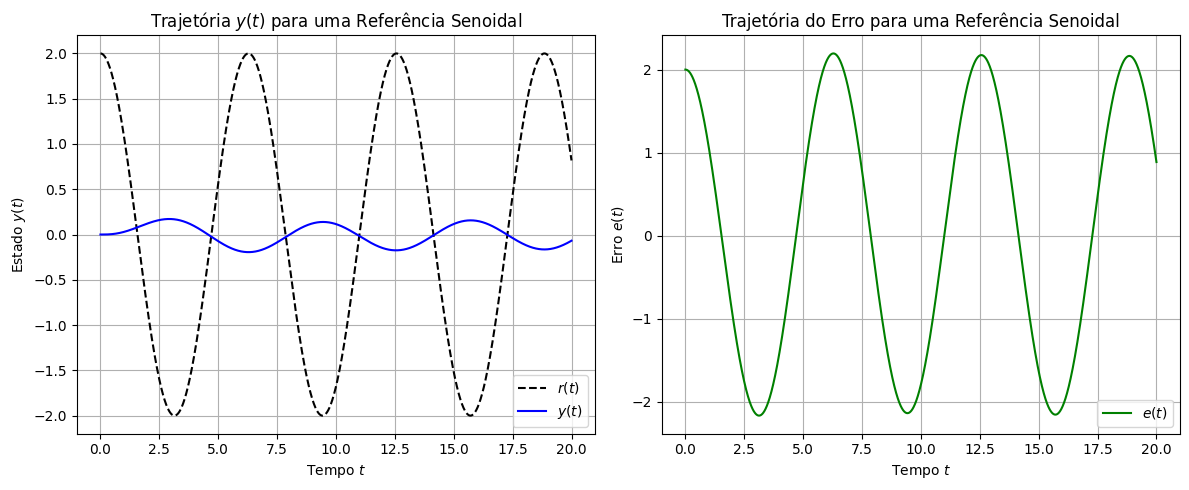

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de simulação
tempo_final = 20
passo = 0.001
condicao_inicial = [0, 0, 0]  # Condição inicial
beta = 1

# Ganhos do controlador PI
K = 0.15

# Ganhos de realimentação para linearização
a0 = -3  # Ganho de realimentação para x1
a1 = 2   # Ganho de realimentação para x2

r = lambda t : 2 * np.cos(t)  # Nova referência

# Definição do sistema de equações diferenciais com realimentação
def sistema(y, r, a0, a1, beta):
    x1, x2, e_int = y
    # Controle por realimentação linearizante
    e = r - x1
    v = K * e_int
    w = v + (0.5 - beta * x1**2) * x2 - a1 * x2 - a0 * x1
    dx1_dt = x2
    dx2_dt = w - (0.5 - x1**2) * x2 - 4 * x1
    de_ind_dt = e
    return np.array([dx1_dt, dx2_dt, de_ind_dt])

# Método de Euler para integração com passo fixo
def solver(sistema, y0, t_final, h, a0, a1, beta, r):
    t = np.arange(0, t_final, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i-1] + h * sistema(y[i-1], r(t[i-1]), a0, a1, beta)
    return t, y

# Preparando o primeiro gráfico no espaço de estados (x1, x2)
plt.figure(figsize=(12, 5))

t, y = solver(sistema, condicao_inicial, tempo_final, passo, a0, a1, beta, r)
x1, x2 = y[:, 0], y[:, 1]

# Subplot para trajetória x1(t) em função do tempo
plt.subplot(1, 2, 1)
plt.plot(t, r(t), 'k--', label="$r(t)$")
plt.plot(t, x1, 'b-', label="$y(t)$")
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title(f"Trajetória $y(t)$ para uma Referência Senoidal")
plt.legend(loc="lower right")
plt.grid()

# Subplot para as trajetórias e(t) em função do tempo
plt.subplot(1, 2, 2)
plt.plot(t, r(t) - x1, label=f"$e(t)$", color="green")
plt.xlabel("Tempo $t$")
plt.ylabel("Erro $e(t)$")
plt.title(f"Trajetória do Erro para uma Referência Senoidal")
plt.legend(loc="lower right")
plt.grid()

# Exibindo os gráficos
plt.tight_layout()
plt.show()

Text(0.5, 0.98, '')

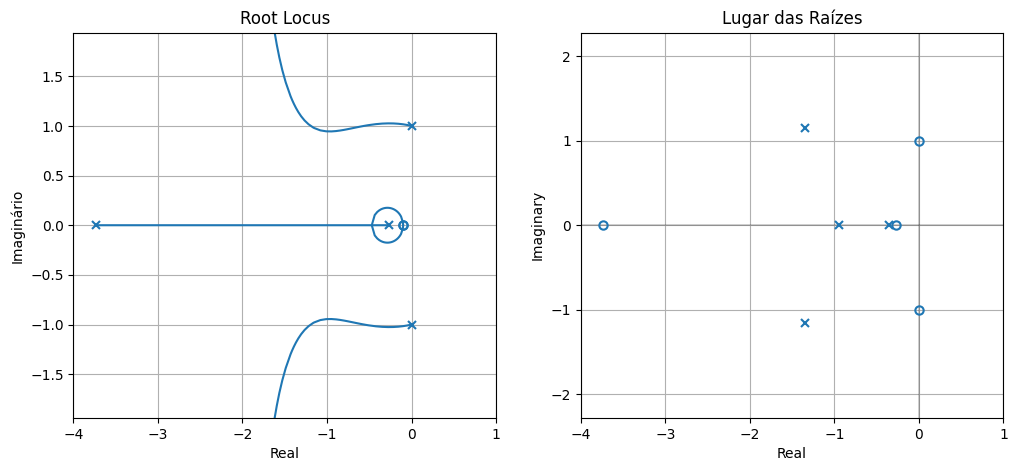

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Definir os ganhos do controlador PI
K = 5
z1 = 0.1
z2 = z1
Kd = K
Kp = K * (z1 + z2)
Ki = K * z1 * z2
wn = 1

# Criar as funções de transferência para o controlador PI e para a planta
C = ctrl.TransferFunction([1], [1, 4, 1])
G = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0, wn ** 2])

# Função de transferência em malha aberta com o controlador PI
CG = C * G

# Diagrama de Root Locus
fig = plt.figure(figsize=(12, 5))

# Configurações do gráfico
plt.subplot(1, 2, 1)
ctrl.root_locus(CG)
plt.title("Root Locus")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.xlim(-4,1)

plt.grid()

# Destaque dos polos e zeros em malha fechada
plt.subplot(1, 2, 2)
plt.title("Lugar das Raízes")
plt.xlabel("Real")
plt.ylabel("Imaginário")
ctrl.pzmap(1 / (1 + CG))
plt.xlim(-4,1)

plt.grid()

fig.suptitle('')

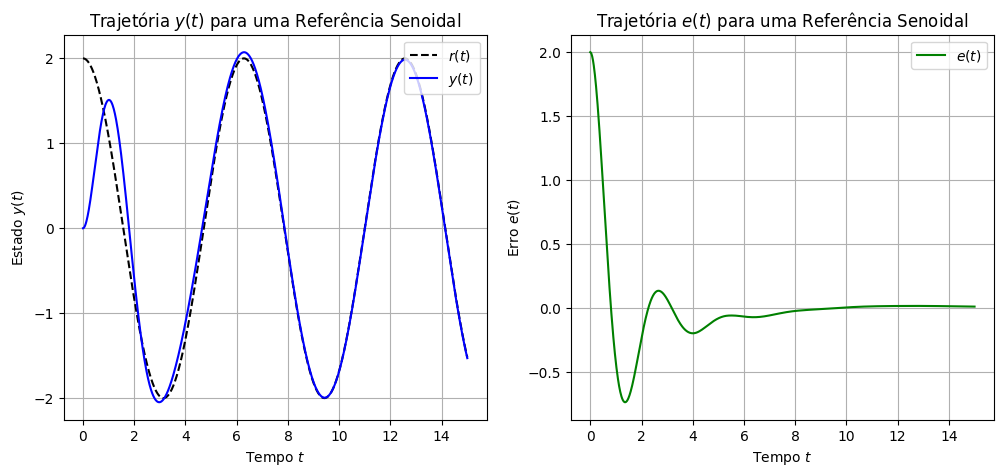

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Define the plant and controller in Laplace domain
K = 5
z1 = 0.1
z2 = z1
wn = 1
beta = 1.0
a0 = -3.0
a1 = 2.0
t = np.linspace(0, 15, 1000)
r = 2 * np.cos(t)
dr_dt = lambda t: -2 * np.sin(t)

# Plant
def sistema(t, x, u, params):
    a0 = params.get('a0')
    a1 = params.get('a1')
    beta = params.get('beta')

    x1, x2, e_int, e_int_int, w_int, w_int_int = x
    r, = u

    e = r - x1
    w = K * (e + (z1 + z2) * e_int + z1 * z2 * e_int_int) - wn ** 2 * w_int_int

    v = w + (0.5 - beta * x1**2) * x2 - a0 * x1 - a1 * x2

    dx1_dt = x2
    dx2_dt = v - (0.5 - x1**2) * x2 - 4 * x1
    de_int_dt  = e
    de_int_int_dt = e_int
    dw_int_dt  = w
    dw_int_int_dt = w_int
    return [dx1_dt, dx2_dt, de_int_dt, de_int_int_dt, dw_int_dt, dw_int_int_dt]

def sistema_out(t, x, u, params): return x[0]

nl_plant = ctrl.NonlinearIOSystem(
    sistema, sistema_out,
    inputs=1, states=6, outputs=1,
    params={'a0': a0, 'a1': a1, 'beta': beta}
)

closed_loop = ctrl.feedback(nl_plant)

# Simulate the closed-loop system response
t, y = ctrl.input_output_response(nl_plant, t, r)
error = r - y

# Plot the results
plt.figure(figsize=(12, 5))

# Subplot para trajetória x1(t) em função do tempo
plt.subplot(1, 2, 1)
plt.plot(t, r, 'k--', label="$r(t)$")
plt.plot(t, y, 'b-', label="$y(t)$")
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title(f"Trajetória $y(t)$ para uma Referência Senoidal")
plt.legend(loc="upper right")
plt.grid()

# Subplot para as trajetórias e(t) em função do tempo
plt.subplot(1, 2, 2)
plt.plot(t, error, label=f"$e(t)$", color="green")
plt.xlabel("Tempo $t$")
plt.ylabel("Erro $e(t)$")
plt.title(f"Trajetória $e(t)$ para uma Referência Senoidal")
plt.legend(loc="upper right")
plt.grid()

# Exibindo os gráficos
plt.show()

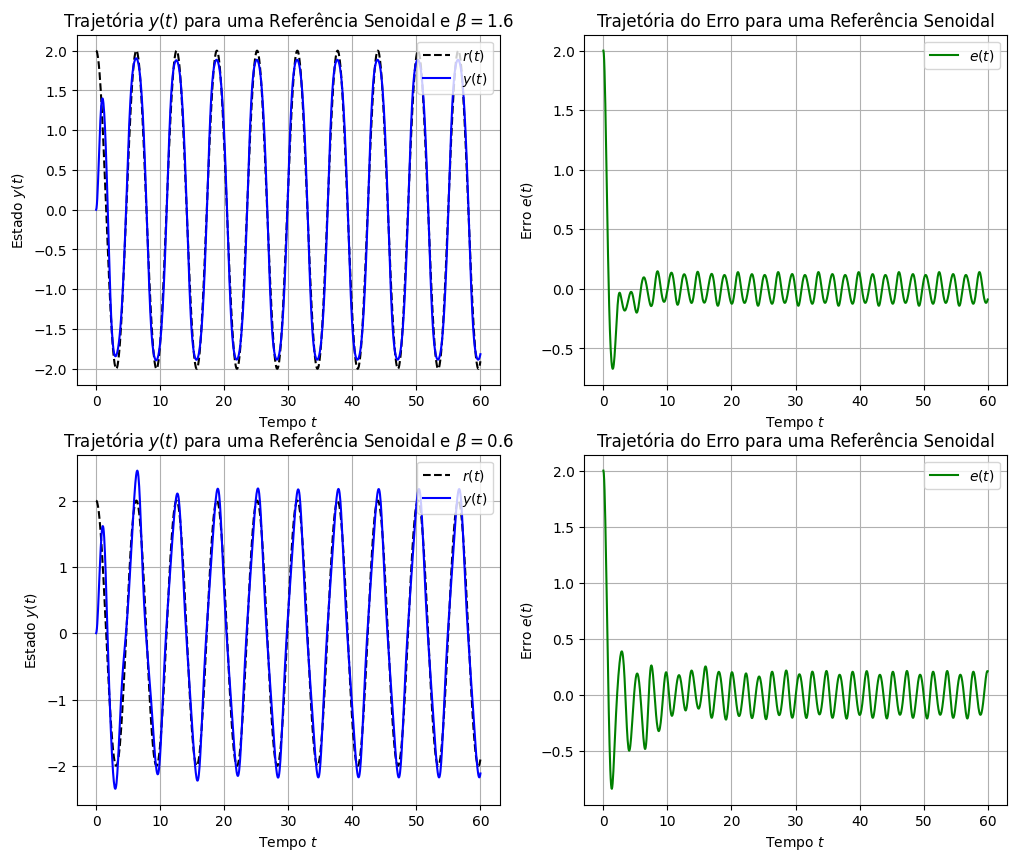

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Define the plant and controller in Laplace domain
K = 5
z1 = 0.1
z2 = z1
wn = 1
beta = 1.6
a0 = -3.0
a1 = 2.0
t = np.linspace(0, 60, 1000)
r = 2 * np.cos(t)
dr_dt = lambda t: -2 * np.sin(t)

# Plant
def sistema(t, x, u, params):
    a0 = params.get('a0')
    a1 = params.get('a1')
    beta = params.get('beta')

    x1, x2, e_int, e_int_int, w_int, w_int_int = x
    r, = u

    e = r - x1
    w = K * (e + (z1 + z2) * e_int + z1 * z2 * e_int_int) - wn ** 2 * w_int_int

    v = w + (0.5 - beta * x1**2) * x2 - a0 * x1 - a1 * x2

    dx1_dt = x2
    dx2_dt = v - (0.5 - x1**2) * x2 - 4 * x1
    de_int_dt  = e
    de_int_int_dt = e_int
    dw_int_dt  = w
    dw_int_int_dt = w_int
    return [dx1_dt, dx2_dt, de_int_dt, de_int_int_dt, dw_int_dt, dw_int_int_dt]

def sistema_out(t, x, u, params): return x[0]

nl_plant = ctrl.NonlinearIOSystem(
    sistema, sistema_out,
    inputs=1, states=6, outputs=1,
    params={'a0': a0, 'a1': a1, 'beta': beta}
)

closed_loop = ctrl.feedback(nl_plant)

# Simulate the closed-loop system response
t, y = ctrl.input_output_response(nl_plant, t, r)
error = r - y

# Plot the results
plt.figure(figsize=(12, 10))

# Subplot para trajetória x1(t) em função do tempo
plt.subplot(2, 2, 1)
plt.plot(t, r, 'k--', label="$r(t)$")
plt.plot(t, y, 'b-', label="$y(t)$")
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title(f"Trajetória $y(t)$ para uma Referência Senoidal e $\\beta={beta}$")
plt.legend(loc="upper right")
plt.grid()

# Subplot para as trajetórias e(t) em função do tempo
plt.subplot(2, 2, 2)
plt.plot(t, error, label=f"$e(t)$", color="green")
plt.xlabel("Tempo $t$")
plt.ylabel("Erro $e(t)$")
plt.title(f"Trajetória do Erro para uma Referência Senoidal")
plt.legend(loc="upper right")
plt.grid()


beta = 0.6
nl_plant = ctrl.NonlinearIOSystem(
    sistema, sistema_out,
    inputs=1, states=6, outputs=1,
    params={'a0': a0, 'a1': a1, 'beta': beta}
)

closed_loop = ctrl.feedback(nl_plant)

# Simulate the closed-loop system response
t = np.linspace(0, 60,1000)
r = 2 * np.cos(t)
t, y = ctrl.input_output_response(nl_plant, t, r)
error = r - y

# Subplot para trajetória x1(t) em função do tempo
plt.subplot(2, 2, 3)
plt.plot(t, r, 'k--', label="$r(t)$")
plt.plot(t, y, 'b-', label="$y(t)$")
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title(f"Trajetória $y(t)$ para uma Referência Senoidal e $\\beta={beta}$")
plt.legend(loc="upper right")
plt.grid()

# Subplot para as trajetórias e(t) em função do tempo
plt.subplot(2, 2, 4)
plt.plot(t, error, label=f"$e(t)$", color="green")
plt.xlabel("Tempo $t$")
plt.ylabel("Erro $e(t)$")
plt.title(f"Trajetória do Erro para uma Referência Senoidal")
plt.legend(loc="upper right")
plt.grid()

# Exibindo os gráficos
plt.show()